<h1>Final Submission </h1> <br>
Hadar Pinto <br>
Eitan Cohen <br>

**IMPORTS**

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
import scipy.stats as stats
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import shap
warnings.filterwarnings("ignore")

*The Dataframe*

In [5]:
# for using the dataset from the drive
'''
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
shared_folder_path = '/content/drive/My Drive/tables_data'
os.chdir(shared_folder_path)
'''

# for using the dataset locally
df = pd.read_csv('Thyroid_Dataset.csv')

Mounted at /content/drive


<h1>Pipeline Goal</h1>

In this notebook, we aim to predict the likelihood of recurrence in patients diagnosed with thyroid cancer. We will explore various features in the dataset to identify key points that can be used in the final model, such as correlations, orientations, skewness, and more.

**Data Analysis And Visualization**

In [6]:
df.head(3)

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No


All features are categorical, besides the feature Age.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

<h1>Dataset Visualizations</h1>

The following visualization explores how categorical features relate to cancer recurrence status, helping identify potential risk factors or predictive indicators in concise subplots.

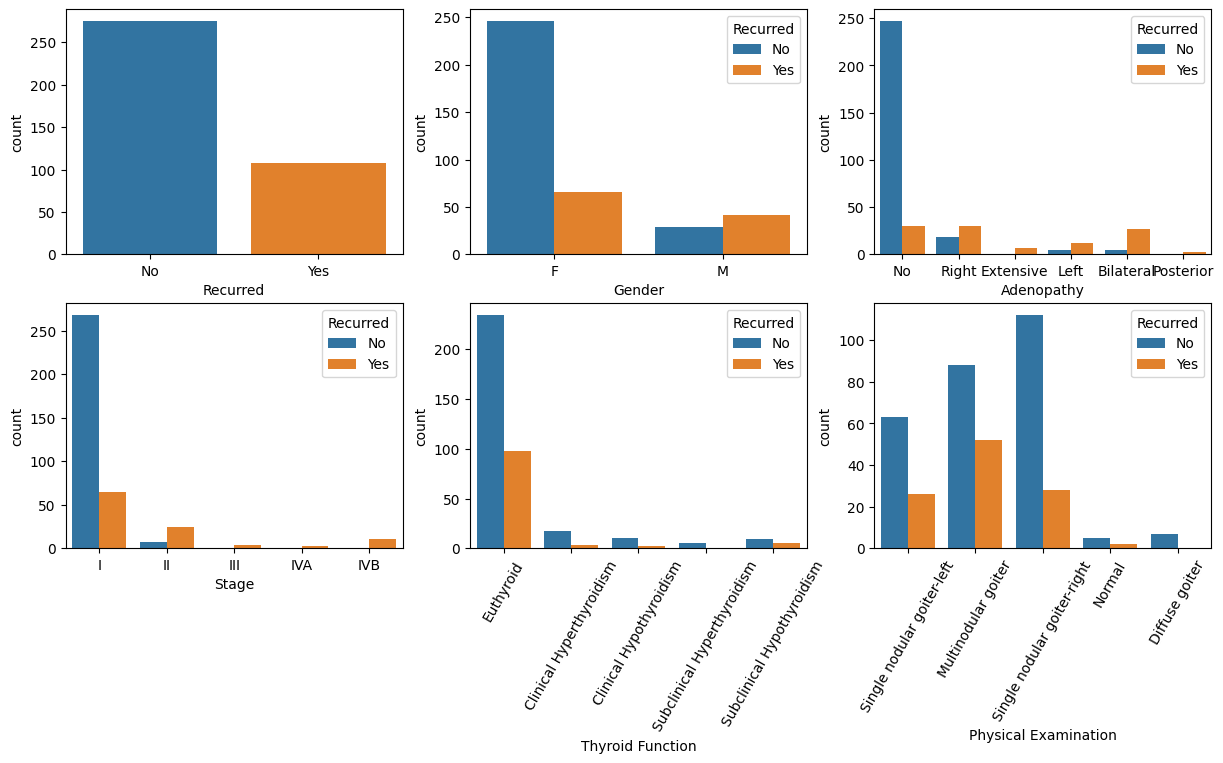

In [10]:
plt.figure(figsize=(20,7))
plt.subplot(241)
sns.countplot(df, x='Recurred', hue='Recurred')
plt.subplot(242)
sns.countplot(df, x='Gender', hue='Recurred')
plt.subplot(243)
sns.countplot(df, x='Adenopathy', hue='Recurred')
plt.subplot(245)
sns.countplot(data=df, x='Stage', hue='Recurred', order=sorted(df['Stage'].unique()))
plt.subplot(246)
sns.countplot(df, x='Thyroid Function', hue='Recurred')
plt.xticks(rotation=60)
plt.subplot(247)
sns.countplot(df, x='Physical Examination', hue='Recurred')
plt.xticks(rotation=60)
plt.show()

<h3>Feature-Label Visualization Insights:</h3>

1. *    Approximately 71.8% of individuals in the dataset are predicted not to experience cancer recurrence.
  *   Thyroid cancer exhibits a higher incidence among women, suggesting a gender-based susceptibility to the disease.

  *  The Majority of participants are confined to Stage I of the disease.
  * Skewness is observed towards a single class in the Adenopathy and Thyroid Function features.

2. **Significant** insight is that the dataset is imbalanced. We shall address  this issue in the upcoming steps.

<h2>Exploring Age Feature:</h2>

The dataset contains only one numerical feature, which is 'Age'. We'll utilize this feature to illustrate its distribution concerning other categorical features in our data while trying to find interesting insights.

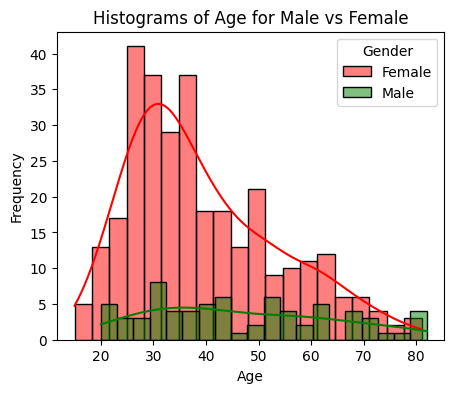

0.7197318617338616

In [ ]:
import pandas as pd
df = pd.read_csv('Thyroid_Dataset.csv')
df_female = df[df['Gender'] == 'F']
df_male = df[df['Gender'] == 'M']
plt.figure(figsize=(5, 4))
sns.histplot(df_female['Age'], color='red', label='Female', kde=True, bins=20, alpha=0.5)
sns.histplot(df_male['Age'], color='green', label='Male', kde=True, bins=20, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histograms of Age for Male vs Female')
plt.legend(title='Gender')
plt.show()
df['Age'].skew()

In addition to the calculated skewness, it's observed that the gender and age distributions exhibit positive skewness (right skewness).

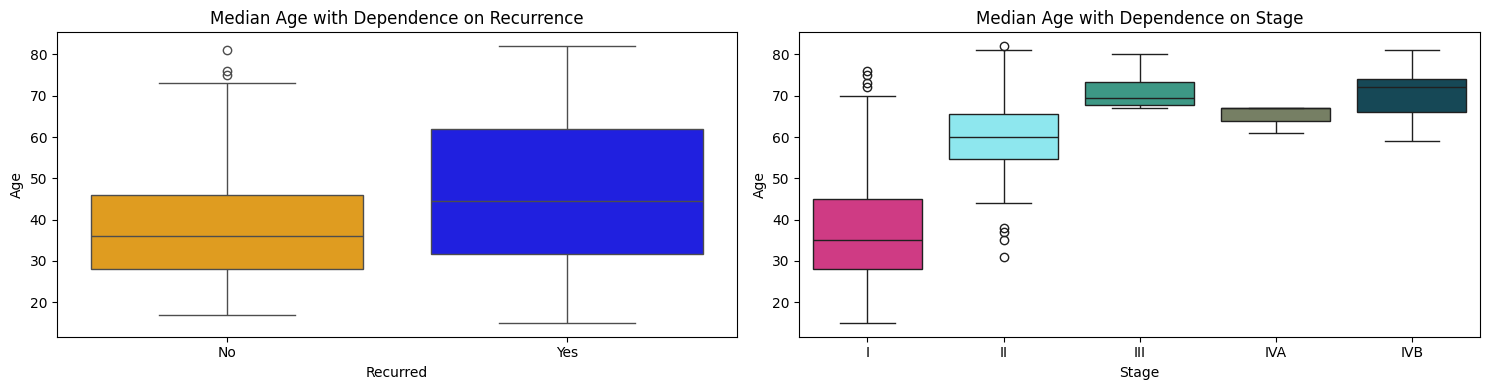

In [ ]:
df = pd.DataFrame(df)
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
recurred_colors = {'Yes': 'blue', 'No': 'orange'}
sns.boxplot(ax=axes[0], x='Recurred', y='Age', data=df, palette=recurred_colors)
axes[0].set_title('Median Age with Dependence on Recurrence')
axes[0].set_xlabel('Recurred')
axes[0].set_ylabel('Age')
stages = sorted(df['Stage'].unique())
color_map = {stage: np.random.rand(3,) for stage in stages}
sns.boxplot(ax=axes[1], x='Stage', y='Age', data=df, palette=color_map, order=stages)
axes[1].set_title('Median Age with Dependence on Stage')
axes[1].set_xlabel('Stage')
axes[1].set_ylabel('Age')
plt.tight_layout()
plt.show()

Insight: Higher Median age patients are teniding to have higher staes at diagnosis and recurrence event. <br>
Based on the visualizations, we have a concern regarding potential outliers. Specifically, we suspect that individuals aged over 70 with stage I may be influencing the dataset in an unexpected manner.


In [ ]:
count = len(df[(df['Stage'] == 'I') & (df['Age'] > 70) & (df['Recurred'] == 'No')])
print(f"Number of patients with Stage 'I', age over 70, and no recurrence: {count}")

Number of patients with Stage 'I', age over 70, and no recurrence: 4


As we expected, older participants who did not experience recurrence also had a lower stage of cancer initially.

Hypothesis :We can assume that there's a high correlation between Smoking and Hx Smoking, indicating that in this dataset, it's uncommon for a person to change their smoking status.



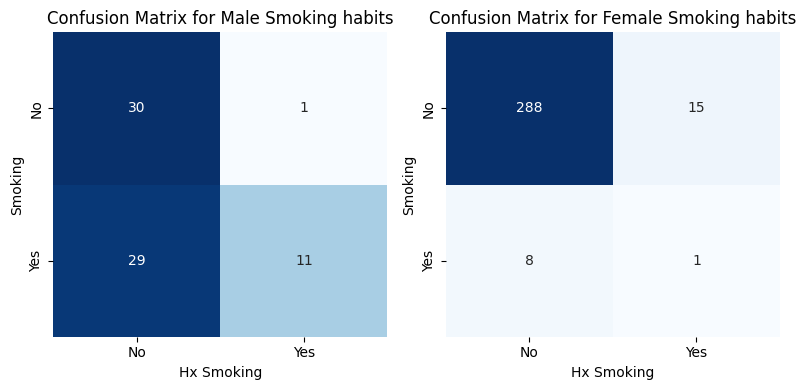

In [ ]:
male_df = df[df['Gender'] == 'M']
female_df = df[df['Gender'] == 'F']
male_conf_matrix = pd.crosstab(male_df['Smoking'], male_df['Hx Smoking'])
female_conf_matrix = pd.crosstab(female_df['Smoking'], female_df['Hx Smoking'])
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(male_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0])
axs[0].set_title('Confusion Matrix for Male Smoking habits')
axs[0].set_xlabel('Hx Smoking')
axs[0].set_ylabel('Smoking')
sns.heatmap(female_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[1])
axs[1].set_title('Confusion Matrix for Female Smoking habits')
axs[1].set_xlabel('Hx Smoking')
axs[1].set_ylabel('Smoking')
plt.tight_layout()
plt.show()

Insight: We can assume that for female there's high correltion in Smoking and Hx Smoking so that in this dataset it's not common that a person changed her Smoking habits for men we can see lower corrletion and more changings in Smoking habits.


<H2> Correlations

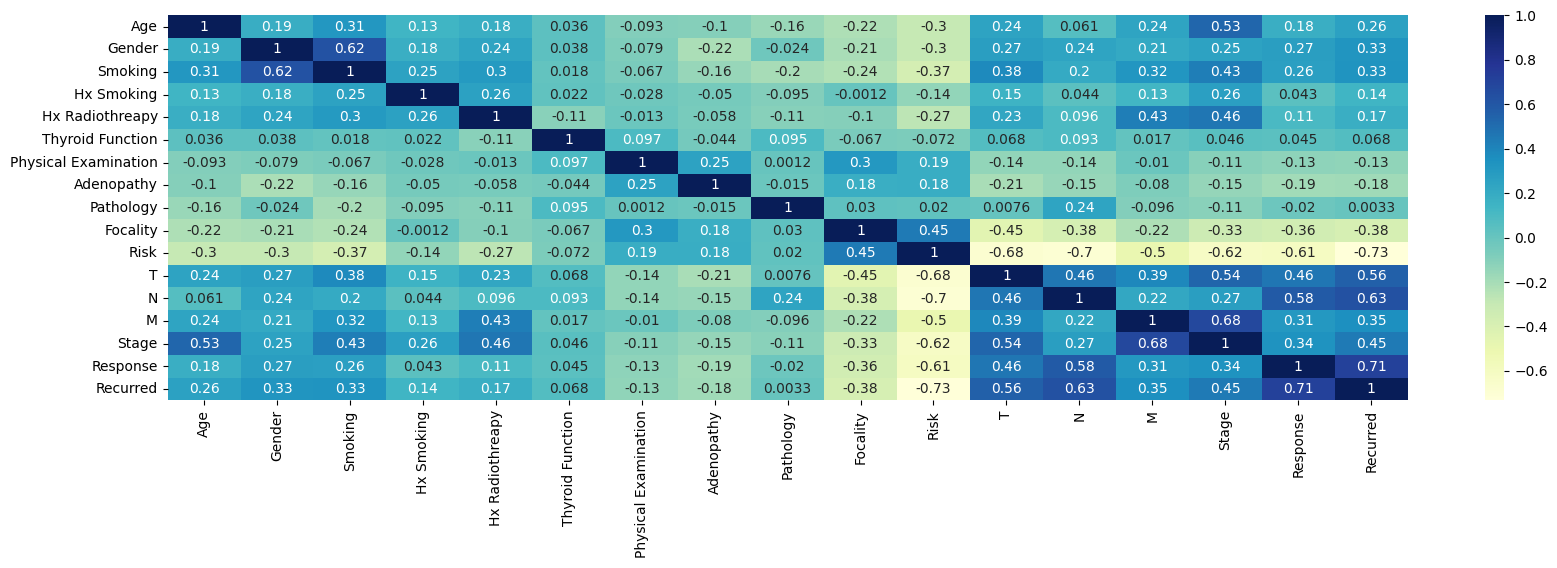

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_columns:
  df[col] = le.fit_transform(df[col])
plt.figure(figsize=(20, 5))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
plt.show()

It's noted that there is a high correlation between the feature Risk to the feature Stage, and between the feature Risk to our label Recurred. <br>
High correlation between a feature and the label risks overfitting, misinterpretation, loss of generalization, and violation of assumptions, therefore we should consider decisions on feature removal. <br>
However, apart from this correlation, there are no other notable high correlations among the features in the dataset.



<h1>Basic XGBoost ML Pipeline</h1>

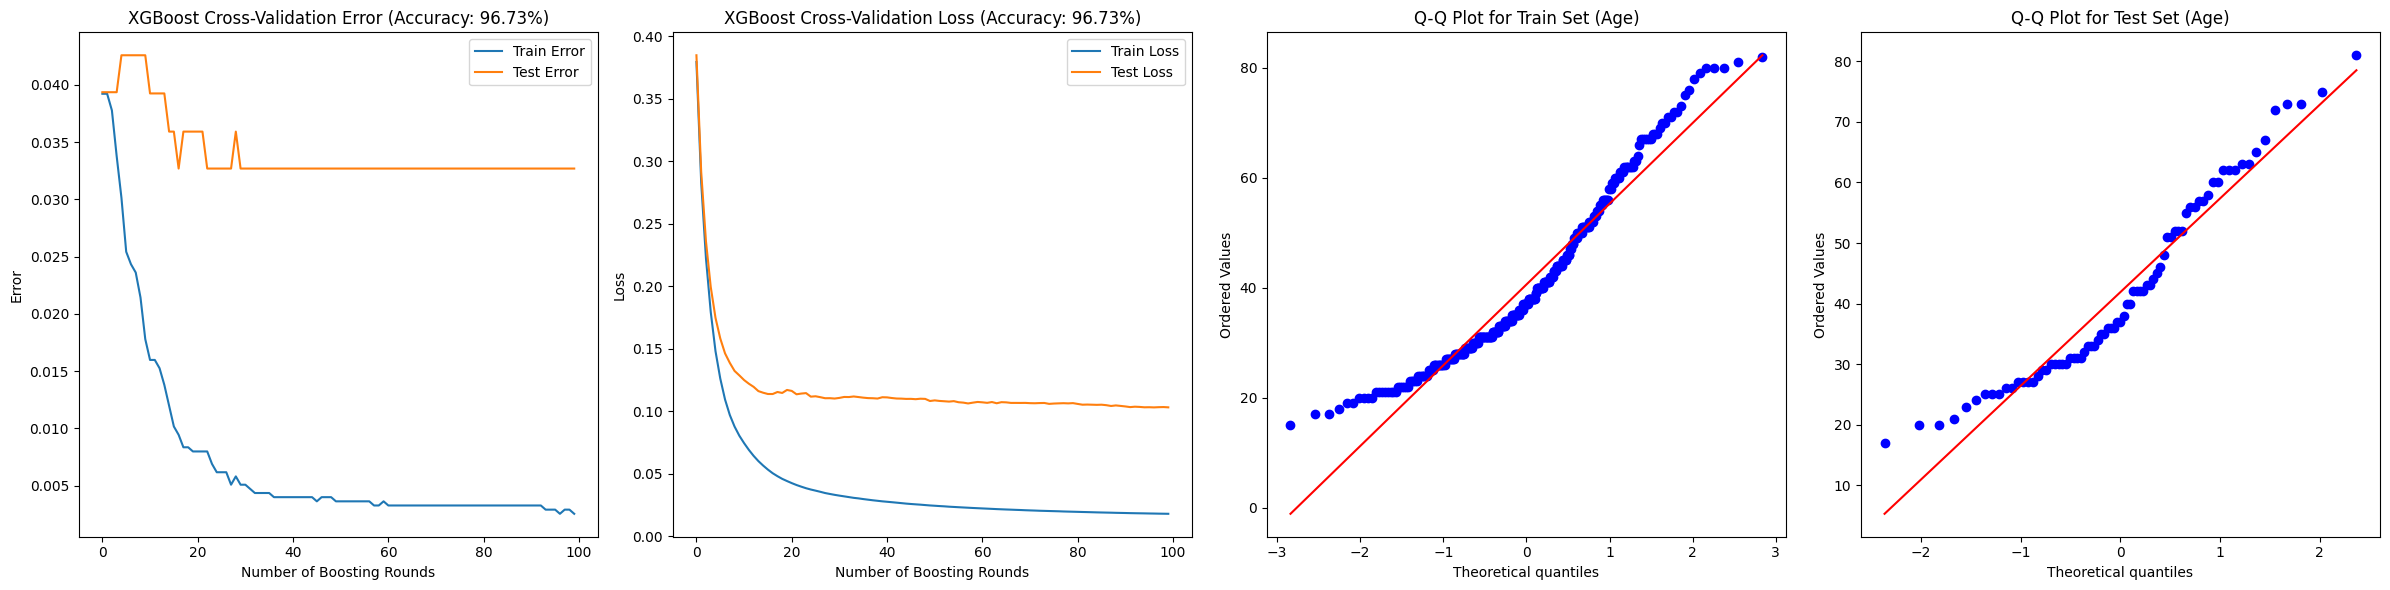

In [39]:
# XGBOOST Model

df = pd.read_csv('Thyroid_Dataset.csv')
X = df.drop(columns=['Recurred'])

y = df['Recurred']
# adapt categorical classes
label_encoders = {}
for feature in X.select_dtypes(include=['object']).columns:
    label_encoders[feature] = LabelEncoder()
    X[feature] = label_encoders[feature].fit_transform(X[feature])
y = y.replace({'Yes': 1, 'No': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
model = xgb.XGBClassifier()
cv_results = xgb.cv(params=model.get_xgb_params(),
                    dtrain=xgb.DMatrix(X_train, label=y_train),
                    num_boost_round=100,
                    nfold=10,
                    metrics=['logloss', 'error'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = 1 - cv_results['test-error-mean'].iloc[-1]

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot cross-validation error
axes[0].plot(cv_results['train-error-mean'], label='Train Error')
axes[0].plot(cv_results['test-error-mean'], label='Test Error')
axes[0].set_xlabel('Number of Boosting Rounds')
axes[0].set_ylabel('Error')
axes[0].set_title('XGBoost Cross-Validation Error (Accuracy: {:.2f}%)'.format(accuracy*100))
axes[0].legend()

# Plot cross-validation loss
axes[1].plot(cv_results['train-logloss-mean'], label='Train Loss')
axes[1].plot(cv_results['test-logloss-mean'], label='Test Loss')
axes[1].set_xlabel('Number of Boosting Rounds')
axes[1].set_ylabel('Loss')
axes[1].set_title('XGBoost Cross-Validation Loss (Accuracy: {:.2f}%)'.format(accuracy*100))
axes[1].legend()

# Plot Q-Q plots
stats.probplot(X_train['Age'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot for Train Set (Age)')
axes[2].set_xlabel('Theoretical quantiles')
axes[2].set_ylabel('Ordered Values')

stats.probplot(X_test['Age'], dist="norm", plot=axes[3])
axes[3].set_title('Q-Q Plot for Test Set (Age)')
axes[3].set_xlabel('Theoretical quantiles')
axes[3].set_ylabel('Ordered Values')

plt.tight_layout()
plt.show()

In [41]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy on the test set
accuracy_test = (y_pred == y_test).mean()
print(f" Test Set Accuracy: {accuracy_test * 100:.2f}%")

 Test Set Accuracy: 93.51%


Results:<br>
The Q-Q plots indicate that the train and test sets have similar distributions, as expected.<br>
The XGBoost model achieved high performance with an accuracy of 93%.<br>
Based on the plots of the loss and error, we might assume that there are some issue, which we will address in our next steps.

<h1>Improvement ML Pipeline</h1>


In our benchmark pipeline model, we achieved a commendable accuracy of 93%. To enhance our pipeline further, we'll shift our focus to the model's ability to predict 'recurred' samples exclusively, meaning that we'll exclude examples labeled 'not recurred' and concentrate on refining the model's predictions, prioritizing the reduction of false-positive classifications.

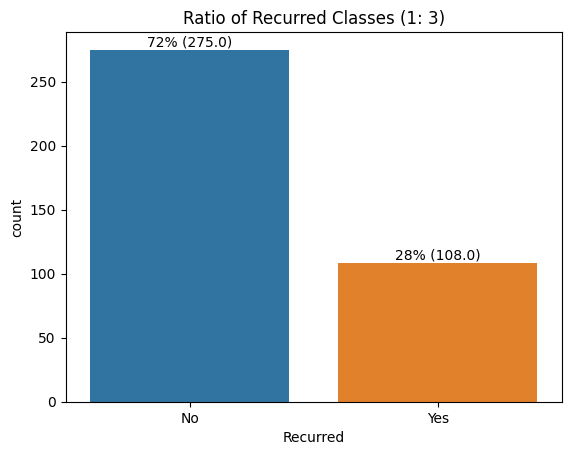

In [43]:
ax = sns.countplot(df, x='Recurred', hue='Recurred')
counts = df['Recurred'].value_counts()
ratio = counts[0] / counts[1]
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.0f}% ({})'.format(height / total * 100, height),
            ha="center")
ax.set_title('Ratio of Recurred Classes (1: {:.0f})'.format(ratio))
plt.show()


The dataset presents two primary challenges: imbalance and small size.<br>
 To address these, we employ several techniques:
  1. We implement a downsample-upweight strategy to balance the class distribution.
  2. We apply Synthetic Minority Over-sampling Technique (SMOTE) to augment the dataset.
  3. We tackle false-positive samples and enhance the model's accuracy through targeted adjustments.<br>

These methods aim to mitigate the impact of imbalance and small sample size, thereby improving the robustness and effectiveness of the analysis.




Accuracy is: 93.5064935064935 %
Accuracy yes is: 80.76923076923077 %


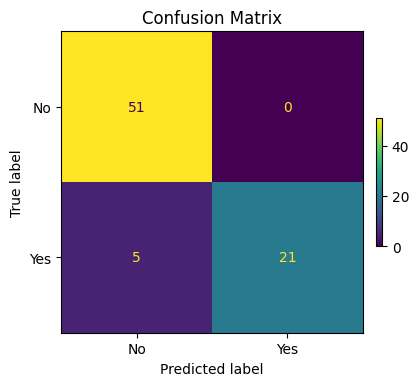

In [17]:
from sklearn import metrics
df = pd.read_csv('Thyroid_Dataset.csv')
X = df.drop(columns=['Recurred'])

y = df['Recurred']
# adapt categorical classes
label_encoders = {}
for feature in X.select_dtypes(include=['object']).columns:
    label_encoders[feature] = LabelEncoder()
    X[feature] = label_encoders[feature].fit_transform(X[feature])
y = y.replace({'Yes': 1, 'No': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

model = xgb.XGBClassifier()
cv_results = xgb.cv(params=model.get_xgb_params(),
                    dtrain=xgb.DMatrix(X_train, label=y_train),
                    nfold=10,
                    metrics=['logloss', 'error'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = (y_pred == y_test).mean()
print("Accuracy is:", accuracy*100, "%")
X_test_label_yes = X_test[y_test==1]
y_test_lablel_yes = y_test[y_test==1]
y_pred_yes = model.predict(X_test_label_yes)
accuracy_yes = (y_pred_yes == y_test_lablel_yes).mean()
print("Accuracy yes is:", accuracy_yes*100, "%")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['No', 'Yes'])
display.plot(ax=ax)
display.ax_.set_title("Confusion Matrix")
display.im_.colorbar.remove()
display.ax_.set_xlabel('Predicted label')
display.ax_.set_ylabel('True label')

fig.tight_layout()
fig.colorbar(display.im_, ax=ax, fraction=0.02, pad=0.04)
plt.show()

Insight: </br>
Out of 26 samples labeled as 'Yes', the model incorrectly predicted 5 of them as 'No', resulting in a 20% false-positive rate. This suggests that the model's performance in identifying positive cases (Recurred = 'Yes') is not optimal, indicating a need for improvement to reduce false positives. Furthermore, the model achieved 100% accuracy in predicting 'No', indicating a focus on negative cases during training, likely due to the imbalance between 'Yes' and 'No' instances. In medical applications, minimizing false positives is crucial, highlighting the need to address this issue for more reliable predictions.

<h2>Downsample-Upweight</h2>

An effective way to handle imbalanced data is to downsample and upweight the majority class. We shall define those two new terms, follow up by training on a disproportionately low subset of the majority class examples.

In [44]:
for i in range(40,60,10):
  for random_state in range(20):
    acc_arr = []
    acc_yes_arr = []
    percentage = i / 100
    df_majority = df[df['Recurred'] == 'No']
    df_minority = df[df['Recurred'] == 'Yes']
    df_majority_downsampled = resample(df_majority,
                                      replace=False,
                                      n_samples=int(len(df_majority) * percentage),
                                      random_state=random_state)

    df_new = pd.concat([df_majority_downsampled, df_minority])
    X = df_new.drop(columns=['Recurred'])
    y = df_new['Recurred']
    label_encoders = {}
    for feature in X.select_dtypes(include=['object']).columns:
        label_encoders[feature] = LabelEncoder()
        X[feature] = label_encoders[feature].fit_transform(X[feature])
    y = y.replace({'Yes': 0, 'No': 1})
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    scale_pos_weight = len(df_majority) / len(df_minority)

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'scale_pos_weight': scale_pos_weight
    }

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtest)
    binary_preds = (preds > 0.5).astype(int)
    # Calculate accuracy
    accuracy = (binary_preds == y_test).mean()

    X_test_yes = X_test[y_test == 0]
    y_test_yes = y_test[y_test == 0]
    dtest_yes = xgb.DMatrix(X_test_yes, label=y_test_yes, enable_categorical=True)

    # Create the DMatrix with enable_categorical=True
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'scale_pos_weight': scale_pos_weight
    }
    y_pred_yes = bst.predict(dtest_yes)
    binary_preds_yes = (y_pred_yes > 0.5).astype(int)
    # Calculate accuracy
    accuracy_yes = (binary_preds_yes == y_test_yes).mean()

    acc_arr.append(accuracy)
    acc_yes_arr.append(accuracy_yes)

  print(f" for down-sampling {i}% of the dataset: Accuracy on test set: {np.average(accuracy) *100:.2f}% || for yes {np.average(accuracy_yes)*100:.2f}%")

 for down-sampling 40% of the dataset: Accuracy on test set: 93.18% || for yes 88.00%
 for down-sampling 50% of the dataset: Accuracy on test set: 87.76% || for yes 81.48%


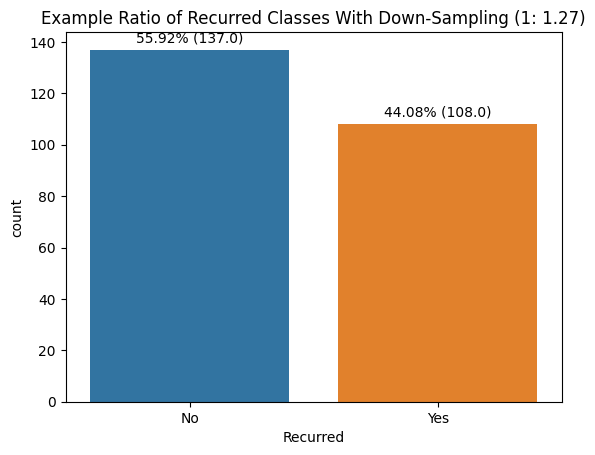

In [45]:
ax = sns.countplot(df_new, x='Recurred', hue='Recurred')
counts = df_new['Recurred'].value_counts()
ratio = counts[0] / counts[1]
total = len(df_new)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}% ({})'.format(height / total * 100, height),
            ha="center")
ax.set_title('Example Ratio of Recurred Classes With Down-Sampling (1: {:.2f})'.format(ratio))
plt.show()

insights: <br>

Utilizing the downsample-upweight technique markedly boosts accuracy, yet addressing false positives in the test set remains a challenge. Notably, optimal performance aligns with the label distribution, particularly evident at 20% and 30%, representing around 28% of the dataset. These insights underscore the strategy's effectiveness in mitigating data imbalance challenges.

<h3>SMOTE</h3>

SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. It aims to balance class distribution by randomly increasing minority class examples by replicating them.

In [33]:
acc = []
acc_yes = []

for i in range(21):
  X = df.drop(columns=['Recurred'])
  y = df['Recurred']
  label_encoders = {}
  for feature in X.select_dtypes(include=['object']).columns:
      label_encoders[feature] = LabelEncoder()
      X[feature] = label_encoders[feature].fit_transform(X[feature])
  y = y.replace({'Yes': 1, 'No': 0})
  smote = SMOTE(sampling_strategy="minority", random_state=i)
  X, y = smote.fit_resample(X, y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

  model = xgb.XGBClassifier()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy_test = accuracy_score(y_test, y_pred)

  X_test_label_yes = X_test[y_test==1]
  y_test_lablel_yes = y_test[y_test==1]
  y_pred_yes = model.predict(X_test_label_yes)
  accuracy_yes = (y_pred_yes == y_test_lablel_yes).mean()
  acc.append(accuracy_test)
  acc_yes.append(accuracy_yes)


print(f" mean final accuracy {np.average(acc)*100:.2f}%")
print(f" mean final for yes accuracy {np.average(acc_yes)*100:.2f}%")

 mean final accuracy 96.15%
 mean final for yes accuracy 97.22%


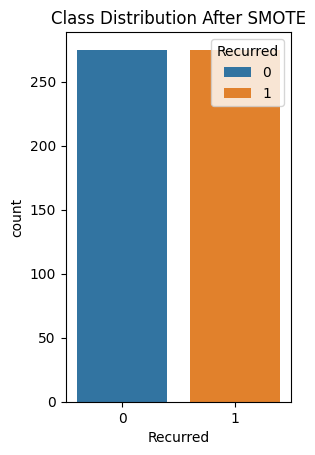

In [32]:
plt.subplot(1, 2, 2)
sns.countplot(x=y, hue=y)
plt.title('Class Distribution After SMOTE')
plt.show()

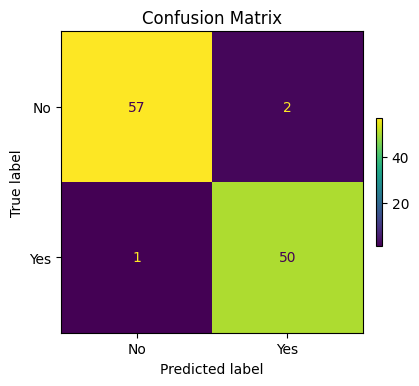

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['No', 'Yes'])
display.plot(ax=ax)
display.ax_.set_title("Confusion Matrix")
display.im_.colorbar.remove()
display.ax_.set_xlabel('Predicted label')
display.ax_.set_ylabel('True label')

fig.tight_layout()
fig.colorbar(display.im_, ax=ax, fraction=0.02, pad=0.04)
plt.show()

Insights: <br>


False-positive rates show significant improvement with SMOTE-enhanced models, demonstrating superior performance compared to the baseline. This enhancement underscores SMOTE's effectiveness in addressing class imbalance, leading to a more balanced dataset and improved model performance.

<h1>Analyzing the Model Performence</h1>


Analyze using SHAP

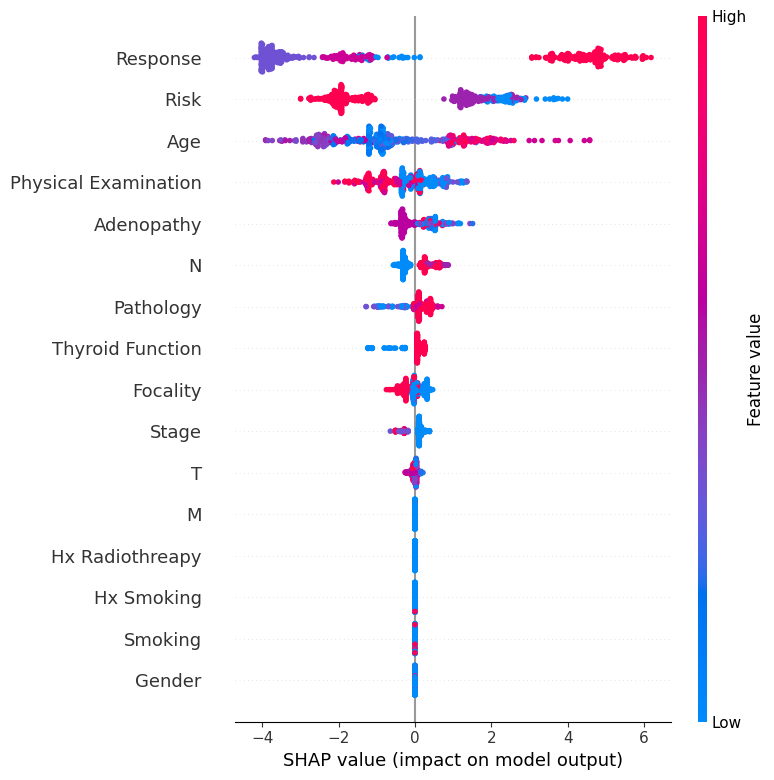

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

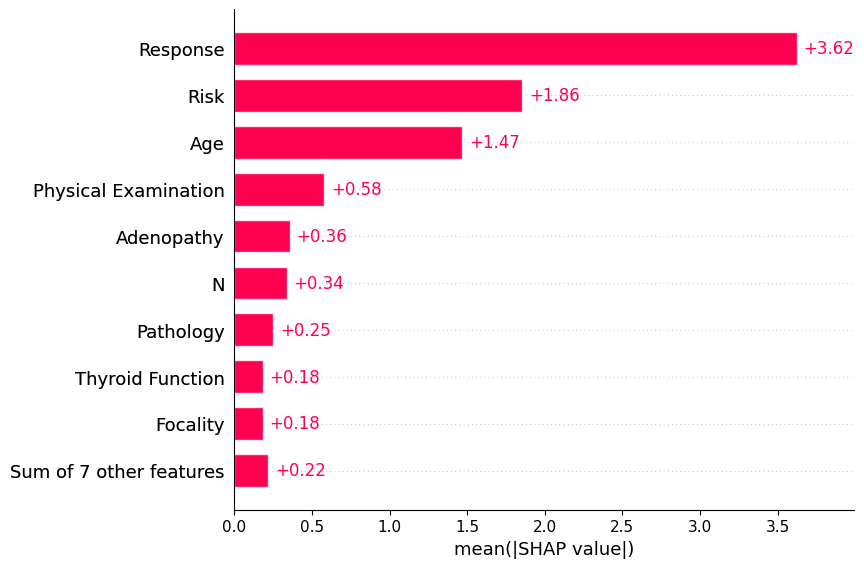

In [ ]:
shap.plots.bar(explainer(X))

Upon analyzing SHAP values:
1. **'Response'** emerges as a crucial factor influencing predictions.
2. 'Risk', 'Age' Are also likley to have infulenece to the predictions.
3. Other features exhibit minimal impact, while some of the other fetures can be categorized even as limited relevance to the prediction.



<h1>Full Pipeline Summary</h1>

In this  project, we started with a basic decision tree of XGBoost. We achieved high accuracy for classifying samples as "recurred" or "not recurred."

Upon analyzing the dataset, we found that it is imbalanced, which could lead to an increase in false-positive mistakes. Given the medical nature of the dataset, avoiding false positives is crucial.

Our first method to address this imbalance was to use a downsampling-upweighting approach. We decreased the number of "Yes" samples to be almost equal to the "No" samples and then gave them more weight to represent the original data. However, this method only slightly increased accuracy.

Next, we tried using SMOTE to generate more "No" samples. This method was more successful, as the model achieved higher accuracy for the minority class and for all samples by adjusting its parameters values during training.

To ensure the results were consistent and not achieved randomly, we used seed values. We calculated the average accuracies of a number of models achieved with different seed values.

In summary, the strategies we employed to address imbalanced data proved effective in enhancing model prediction and accuracy. Our observations and demonstrations revealed that a majority of features suffer from imbalance. Therefore, we propose that future efforts should prioritize addressing this issue.

<h1>What Makes This Pipeline Different?</h1>

Our initial pipeline, employing the XGBoost model with default parameters, achieved a successful prediction rate of 93%. As a result, we approached pipeline improvement from a different perspective, emphasizing the focus on predicting true-positive results for thyroid cancer recurrence, rather than comparing results with other ML classifiers. Our pipeline underscores the crucial need for heightened accuracy, especially in positive predictions. Furthermore, it introduces down-sampling and SMOTE as methods to address challenges posed by small dataset sizes and imbalanced dataset, showcasing our commitment to exploring multiple strategies effectively.